In [4]:
import copy
import os.path as osp

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential

import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.utils import remove_self_loops
import torch_geometric

from detanet_model import *

In [5]:
device = 'cpu'

In [23]:
target = 2  # Target property = homo, see https://pytorch-geometric.readthedocs.io/en/2.6.1/generated/torch_geometric.datasets.QM9.html for correct number 

def preprocess_data(data):
    #Create a copy to avoid in place modification

    new_dataset = []

    for molecule in data:
        pos = molecule.pos
        z = molecule.z
        homo = molecule.y.squeeze()[2]
        lumo = molecule.y.squeeze()[3]
        gap = molecule.y.squeeze()[4]

        

        # Create the dataset entry
        data_entry = torch_geometric.data.Data(
            pos=pos.to(torch.float32),    # Atomic positions
            z=torch.LongTensor(z),        # Atomic numbers
            homo=homo.to(torch.float32), # Polarizability tensor (target
            lumo = lumo.to(torch.float32),
            gap = gap.to(torch.float32)    
        )

        new_dataset.append(data_entry)
    return new_dataset



In [24]:
path = osp.join('..', 'data', 'QM9')
dataset = QM9(path).shuffle()
print(dataset[0])

Data(x=[17, 11], edge_index=[2, 34], edge_attr=[34, 4], y=[1, 19], pos=[17, 3], z=[17], smiles='[H][N-][C+]([H])O[C@@]1([H])C([H])([H])[C@@]1([H])O[C+]([H])[N-][H]', name='gdb_51600', idx=[1])


In [25]:
'''We divided the dataset evenly and used 5% of the data for testing and other for training:'''
dataset = preprocess_data(dataset)
print(dataset[0])


train_datasets=[]
val_datasets=[]
for i in range(len(dataset)):
    if i%20==0:
        val_datasets.append(dataset[i])
    else:
        train_datasets.append(dataset[i])
        
len(train_datasets),len(val_datasets)

Data(pos=[17, 3], z=[17], homo=-6.925297737121582, lumo=0.5768813490867615, gap=7.502179145812988)


(124289, 6542)

In [28]:
for data in train_datasets:
    print("lumo: ", data.lumo)
    print("homo: ", data.homo)
    print("gap: ", data.gap )
    print("z", data.z)
    break



lumo:  tensor(0.2912)
homo:  tensor(-5.4368)
gap:  tensor(5.7280)
z tensor([8, 6, 6, 7, 6, 6, 6, 6, 1, 1, 1, 1, 1])


In [6]:
'''Using torch_Geometric.dataloader.DataLoader Converts a dataset into a batch of 64 molecules of training data.'''
batches=64
trainloader=DataLoader(train_datasets,batch_size=batches,shuffle=True)
valloader=DataLoader(val_datasets,batch_size=batches,shuffle=True)

In [7]:
'''After loading the dataset, we train a model using NPA charge as an example.
 	Firstly, construct an untrained model:'''
model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=9,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=1,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=torch.device(device))

model.train()

DetaNet(
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=128, bias=False)
    (nuclare_emb): Embedding(10, 128)
    (ls): Linear(in_features=128, out_features=128, bias=True)
  )
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=128, out_features=128, bias=True)
          (lk): Linear(in_features=128, out_features=128, bias=True)
          (lv): Linear(in_features=128, out_features=256, bias=True)
          (la): Linear(in_features=256, out_features=256, bias=True)
          (lrbf): Linear(in_features=32, out_features=128, bias=False)
          (lkrbf): Linear(in_features=128, out_features=128, bias=False)
          (lvrbf): Linear(in_featu

In [8]:
print(torch.cuda.is_available())

False


In [13]:
from torch_geometric.nn import global_mean_pool

'''Next, define the trainer and the parameters used for training.'''
class Trainer:
    def __init__(self,model,train_loader,val_loader=None,loss_function=l2loss,device=torch.device(device),
                 optimizer='Adam_amsgrad',lr=5e-4,weight_decay=0):
        self.opt_type=optimizer
        self.device=device
        self.model=model
        self.train_data=train_loader
        self.val_data=val_loader
        self.device=device
        self.opts={'AdamW':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'AdamW_amsgrad':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adam':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'Adam_amsgrad':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adadelta':torch.optim.Adadelta(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'RMSprop':torch.optim.RMSprop(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'SGD':torch.optim.SGD(self.model.parameters(),lr=lr,weight_decay=weight_decay)
        }
        self.optimizer=self.opts[self.opt_type]
        self.loss_function=loss_function
        self.step=-1
    def train(self,num_train,targ,stop_loss=1e-8, val_per_train=50, print_per_epoch=10):
        self.model.train()
        len_train=len(self.train_data)
        for i in range(num_train):
            val_datas=iter(self.val_data)
            for j,batch in enumerate(self.train_data):
                self.step=self.step+1
                torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                out = self.model(pos=batch.pos.to(self.device), z=batch.z.to(self.device),
                                     batch=batch.batch.to(self.device))
                graph_out = global_mean_pool(out, batch.batch)  # Shape: [batch_size, d]
                target = batch[targ].to(self.device)
                loss = self.loss_function(graph_out.reshape(target.shape),target)
                loss.backward()
                self.optimizer.step()
                if (self.step%val_per_train==0) and (self.val_data is not None):
                    val_batch = next(val_datas)
                    val_target=val_batch[targ].to(self.device).reshape(-1)

                    val_out = self.model(pos=val_batch.pos.to(self.device), z=val_batch.z.to(self.device),
                    batch=val_batch.batch.to(self.device))

                    # Aggregate node-level outputs to graph-level outputs
                    val_graph_out = global_mean_pool(val_out, val_batch.batch)  # Shape: [val_batch_size, d]

                    # Ensure the shapes match
                    val_loss = self.loss_function(val_graph_out.reshape(val_target.shape), val_target).item()
                    val_mae = l1loss(val_graph_out, val_target).item()
                    val_R2 = R2(val_graph_out, val_target).item()

                    if self.step % print_per_epoch==0:
                        print('Epoch[{}/{}],loss:{:.8f},val_loss:{:.8f},val_mae:{:.8f},val_R2:{:.8f}'
                              .format(self.step,num_train*len_train,loss.item(),val_loss,val_mae,val_R2))

                    assert (loss > stop_loss) or (val_loss > stop_loss),'Training and prediction Loss is less' \
                                                                        ' than cut-off Loss, so training stops'
                elif (self.step % print_per_epoch == 0) and (self.step%val_per_train!=0):
                    print('Epoch[{}/{}],loss:{:.8f}'.format(self.step,num_train*len_train, loss.item()))
                    
    def load_state_and_optimizer(self,state_path=None,optimizer_path=None):
        if state_path is not None:
            state_dict=torch.load(state_path)
            self.model.load_state_dict(state_dict)
        if optimizer_path is not None:
            self.optimizer=torch.load(optimizer_path)

    def save_param(self,path):
        torch.save(self.model.state_dict(),path)

    def save_model(self,path):
        torch.save(self.model, path)

    def save_opt(self,path):
        torch.save(self.optimizer,path)

    def params(self):
        return self.model.state_dict()
    

In [14]:
'''Then, modify the data type and device type'''
device=torch.device('cpu')
dtype=torch.float32
model=model.to(dtype)
model=model.to(device)

In [15]:
'''Finally, using the trainer, training 20 times from a 5e-4 learning rate'''
trainer=Trainer(model,train_loader=trainloader,val_loader=valloader,loss_function=l2loss,lr=5e-4,weight_decay=0,optimizer='AdamW')

In [16]:
trainer.train(num_train=1,targ='y')

Epoch[0/1943],loss:40.64371872,val_loss:35.94981003,val_mae:5.94719601,val_R2:-4478.80810547
Epoch[10/1943],loss:1.77643800
Epoch[20/1943],loss:0.77030885
Epoch[30/1943],loss:1.44904077
Epoch[40/1943],loss:0.74103355
Epoch[50/1943],loss:0.43585786,val_loss:0.44911265,val_mae:0.48343807,val_R2:-71.99038696
Epoch[60/1943],loss:0.43952227
Epoch[70/1943],loss:0.47705412
Epoch[80/1943],loss:0.62001318
Epoch[90/1943],loss:0.75179982
Epoch[100/1943],loss:0.21752797,val_loss:0.31865183,val_mae:0.47467422,val_R2:-65.66029358
Epoch[110/1943],loss:0.51658762
Epoch[120/1943],loss:0.37469721
Epoch[130/1943],loss:0.32675081
Epoch[140/1943],loss:0.28695488
Epoch[150/1943],loss:0.24882981,val_loss:0.19998977,val_mae:0.41605532,val_R2:-75.63143158
Epoch[160/1943],loss:0.28906411
Epoch[170/1943],loss:0.20008424
Epoch[180/1943],loss:0.26013213
Epoch[190/1943],loss:0.12305635
Epoch[200/1943],loss:0.16629326,val_loss:0.12651776,val_mae:0.67349136,val_R2:-123.11518860
Epoch[210/1943],loss:0.17127825
Epoch[2

In [19]:
'''After the training is completed, take out the learnable parameters and save them as a. pth file.'''
state_dict=model.state_dict

state_dict()

OrderedDict([('Embedding.act.alpha',
              tensor([1.0196, 1.0054, 1.0352, 1.0057, 0.9917, 1.0029, 1.0069, 0.9902, 1.0026,
                      1.0077, 0.9943, 0.9933, 1.0125, 1.0095, 1.0116, 0.9897, 1.0007, 1.0233,
                      1.0105, 0.9933, 1.0258, 1.0051, 0.9961, 1.0081, 1.0118, 1.0024, 1.0188,
                      0.9934, 1.0065, 1.0074, 1.0105, 1.0080, 0.9965, 0.9911, 1.0073, 1.0173,
                      0.9962, 1.0083, 0.9997, 0.9937, 1.0065, 0.9985, 1.0060, 0.9933, 1.0084,
                      0.9917, 1.0135, 0.9985, 1.0126, 1.0004, 0.9913, 0.9987, 1.0053, 1.0064,
                      0.9996, 1.0085, 0.9967, 0.9969, 0.9991, 1.0050, 0.9932, 0.9992, 1.0117,
                      1.0020, 1.0058, 0.9917, 1.0059, 1.0073, 1.0216, 1.0068, 1.0066, 1.0233,
                      1.0043, 1.0461, 0.9996, 0.9953, 0.9878, 0.9923, 0.9918, 1.0068, 0.9967,
                      1.0109, 1.0100, 1.0129, 1.0056, 0.9920, 1.0080, 0.9976, 1.0000, 0.9893,
                      1

In [18]:
torch.save(model.state_dict(),'trained_param/homo.pth')

In [14]:
# load model

device=torch.device('cpu')

trained_model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=9,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=1,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=torch.device(device))
state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/homo.pth")
trained_model.load_state_dict(state_dict=state_dict)

/tmp/ipykernel_429375/3306458689.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/hom

<All keys matched successfully>

In [17]:
print("Summation setting:", trained_model.summation)

Summation setting: False


In [16]:
trained_model.train()

DetaNet(
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=128, bias=False)
    (nuclare_emb): Embedding(10, 128)
    (ls): Linear(in_features=128, out_features=128, bias=True)
  )
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=128, out_features=128, bias=True)
          (lk): Linear(in_features=128, out_features=128, bias=True)
          (lv): Linear(in_features=128, out_features=256, bias=True)
          (la): Linear(in_features=256, out_features=256, bias=True)
          (lrbf): Linear(in_features=32, out_features=128, bias=False)
          (lkrbf): Linear(in_features=128, out_features=128, bias=False)
          (lvrbf): Linear(in_featu

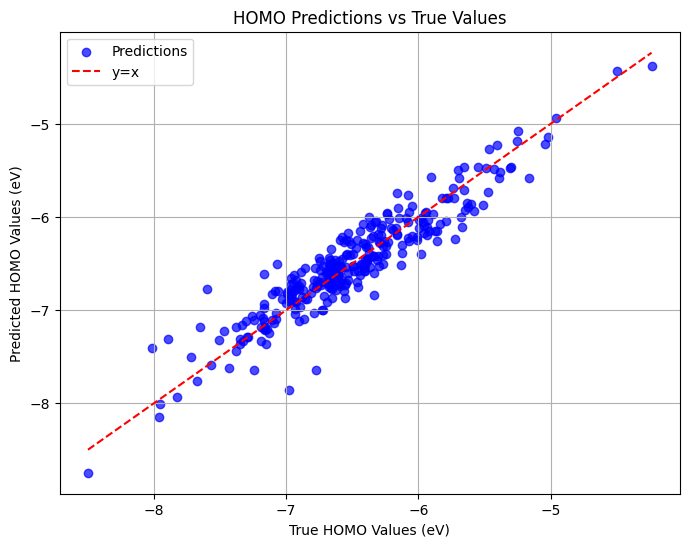

In [20]:
import matplotlib.pyplot as plt
from torch_geometric.nn import global_mean_pool

trained_model.eval()
device=torch.device('cpu')

eval_data = val_datasets[:300]
eval_loader = DataLoader(eval_data, batch_size=1, shuffle=False)

# Get predictions
predictions = []
true_values = []

for batch in eval_loader:
    true_values.append(batch.y)
    with torch.no_grad():
            val_out = trained_model(pos=batch.pos.to(device), z=batch.z.to(device),
                    batch=batch.batch.to(device))
            val_graph_out = global_mean_pool(val_out, batch.batch)  # Shape: [val_batch_size, d]
            predictions.append(val_graph_out.item())

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, c='blue', alpha=0.7, label='Predictions')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True HOMO Values (eV)')
plt.ylabel('Predicted HOMO Values (eV)')
plt.title('HOMO Predictions vs True Values')
plt.legend()
plt.grid(True)

In [37]:
from sklearn.metrics import r2_score
r2 = r2_score(true_values, predictions)
print("Corrected R2:", r2)

Corrected R2: 0.8733291868423835


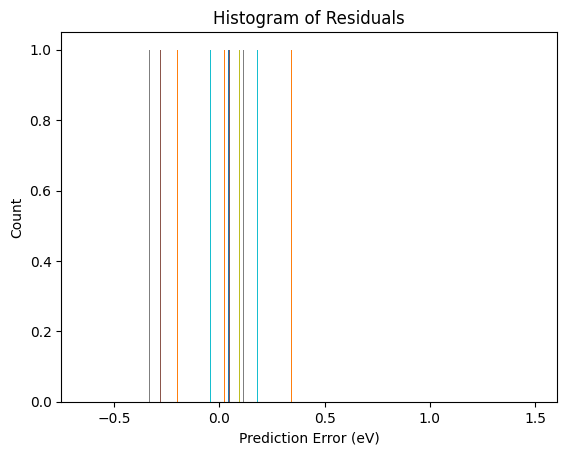

In [35]:
residuals = [true - pred for true, pred in zip(true_values, predictions)]
plt.hist(residuals, bins=30)
plt.xlabel('Prediction Error (eV)')
plt.ylabel('Count')
plt.title('Histogram of Residuals')
plt.show()